In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import grad

import models

In [2]:
data = sio.loadmat("data.mat")
res = data["res"].T
doses = data["doses"].T
Zr = data["cases"].T
Dr = data["deaths"].T
A = data["hospitalized"].T
t = data["time"].T

Zr[Zr <= 0] = 0 # 1e-8
Dr[Dr <= 0] = 0 #1e-8
A[A <= 0] = 0 #1e-8

In [3]:
K = 400
res = res[:K]
doses = doses[:K]
Zr_train = Zr[:K]
Dr_train = Dr[:K]
A_train = A[:K]

t_Zr = t[:K]
t_Dr = t[:K]
t_A = t[:K]

t_ode = t[:K+100]
t_test = t_ode
Zr_test = Zr[:K+100]
Dr_test = Dr[:K+100]
A_test = A[:K+100]
t_A_test = t_test[~np.isnan(A_test)].reshape([-1, 1])

# preprocess nan
doses[np.isnan(doses)] = 0
t_A = t_A[~np.isnan(A_train)].reshape([-1, 1])
A_train = A_train[~np.isnan(A_train)].reshape([-1, 1])
A_test = A_test[~np.isnan(A_test)].reshape([-1, 1])


N = 39512223.0
eta = 1/4
gamma = 1/4
gamma_dw = 1/10
gamma_zw = 1
gamma_h = 1/10
rho = 0.5

In [4]:
# prepare data
t_ode = torch.tensor(t_ode, dtype=torch.float32, requires_grad=True)
t0 = torch.tensor([[0]], dtype=torch.float32)
t_Zr = torch.tensor(t_Zr, dtype=torch.float32)
t_Dr = torch.tensor(t_Dr, dtype=torch.float32)
t_A = torch.tensor(t_A, dtype=torch.float32)

Zr0 = torch.tensor([[0]], dtype=torch.float32)
Dr0 = torch.tensor([[0]], dtype=torch.float32)
A0 = torch.tensor([[0]], dtype=torch.float32)
Zr_train = torch.tensor(Zr_train, dtype=torch.float32)
Dr_train = torch.tensor(Dr_train, dtype=torch.float32)
A_train = torch.tensor(A_train, dtype=torch.float32)

In [5]:
# prepare model
u = models.NN(
    layers=[1, 50, 50, 50, 50, 50, 9],
    activation=torch.tanh,
    input_transform=lambda t: t/500,
    output_transform=torch.exp,
)
beta = models.NN(
    layers=[1, 50, 50, 1],
    activation=torch.tanh,
    input_transform=lambda t: t/500,
    output_transform=torch.exp,
)
L0 = torch.tensor([[1.0]], dtype=torch.float32, requires_grad=True)
logit_p_h = torch.tensor(0.5, dtype=torch.float32, requires_grad=True)
logit_p_d = torch.tensor(0.5, dtype=torch.float32, requires_grad=True)

parameters = list(u.parameters()) + list(beta.parameters()) + [L0, logit_p_h, logit_p_d]
opt = torch.optim.Adam(parameters, lr=0.001)

In [6]:
weights = torch.tensor([1, 1e-10, 1, 1, 1], dtype=torch.float32)

In [7]:
loss1 = []
loss2 = []
loss3 = []
loss4 = []
loss5 = []
for it in range(10000):
    p_h = torch.sigmoid(logit_p_h)
    p_d = torch.sigmoid(logit_p_d)
    args = [
        torch.clip(beta.forward(t_ode), max=1000),
        p_h,
        N, eta, gamma, gamma_dw, gamma_zw, gamma_h,
        p_d,
        rho,
    ]
    Y0 = eta * L0 / gamma
    Z0 = (p_h + rho * (1 - p_h)) * gamma * Y0 / gamma_zw
    H0 = p_h * gamma * Y0 / gamma_h
    D0 = p_d * gamma_h * H0 / gamma_dw
    X0 = torch.clip(N - L0 - Y0 - H0 - D0, min=N/10)
    u0 = torch.concat([X0, L0, Y0, Z0, Zr0, H0, A0, D0, Dr0], dim=-1)
    
    losses = models.loss_function(
        u, 
        t_ode, 
        t0,
        u0,
        t_Zr, Zr_train, 
        t_Dr, Dr_train, 
        t_A, A_train, 
        args,
    )
    loss_value = torch.sum(weights * torch.stack(losses))
    opt.zero_grad()
    loss_value.backward()
    opt.step()
    loss1 += [losses[0].detach().cpu().numpy()]
    loss2 += [losses[1].detach().cpu().numpy()]
    loss3 += [losses[2].detach().cpu().numpy()]
    loss4 += [losses[3].detach().cpu().numpy()]
    loss5 += [losses[4].detach().cpu().numpy()]
    if it % 100 == 0:
        print(it, loss_value.detach().cpu().numpy())

0 232425600.0
100 145357500.0
200 144083400.0
300 144083220.0
400 144083150.0
500 144082340.0
600 89687976.0
700 88360580.0
800 88175656.0
900 88106030.0
1000 88056480.0
1100 88018680.0
1200 87987470.0
1300 87960340.0
1400 87937070.0
1500 87917220.0
1600 87900790.0
1700 87886700.0
1800 87874620.0
1900 87669670.0
2000 10895874.0
2100 9740381.0
2200 9595081.0
2300 9498821.0
2400 9442366.0
2500 9412994.0
2600 9431949.0
2700 9321795.0
2800 9306090.0
2900 9273583.0
3000 9259197.0
3100 9223453.0
3200 9222883.0
3300 9198013.0
3400 9203889.0
3500 9198714.0
3600 9174384.0
3700 9169260.0
3800 9161531.0
3900 9139521.0
4000 8639239.0
4100 8073884.0
4200 8230136.0
4300 7852738.5
4400 7764138.0
4500 7698109.5
4600 7634742.5
4700 7566745.0
4800 7487145.0
4900 7389866.0
5000 7279919.5
5100 7174963.5
5200 7084596.5
5300 7271327.0
5400 6995405.5
5500 6961339.5
5600 6916879.0
5700 7033180.5
5800 7017810.0
5900 6988019.0
6000 6831331.0
6100 6813524.5
6200 6730262.5
6300 5406869.5
6400 5362628.0
6500 53602

In [8]:
u_pred = u.forward(t_ode).detach().cpu()
beta_pred = beta.forward(t_ode).detach().cpu()

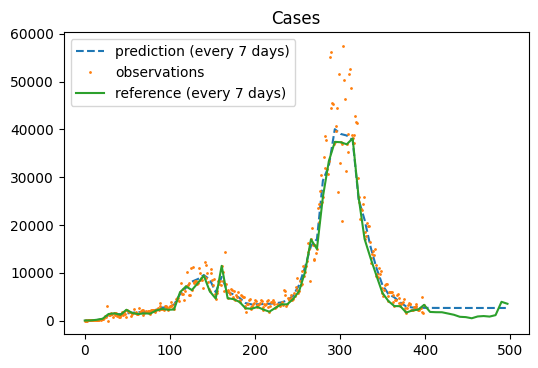

In [9]:
plt.figure(dpi=100)
plt.plot(t_ode.detach().cpu()[::7], u_pred[:, 4:5][::7], '--', label="prediction (every 7 days)")
plt.plot(t_Zr, Zr_train, 'o', markersize=1, label="observations")
plt.plot(t_ode.detach().cpu()[::7], Zr_test[::7], label="reference (every 7 days)")
plt.title("Cases")
plt.legend()

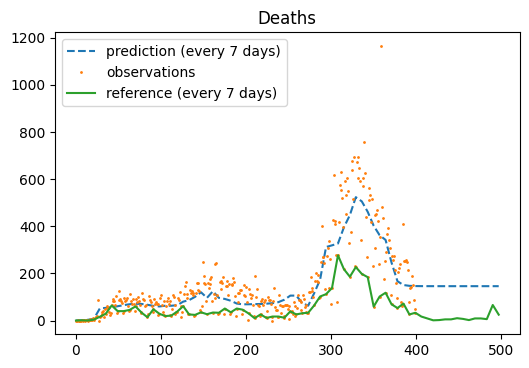

In [10]:
plt.figure(dpi=100)
plt.plot(t_ode.detach().cpu()[::7], u_pred[:, 8:9][::7], '--', label="prediction (every 7 days)")
plt.plot(t_Dr, Dr_train, 'o', markersize=1, label="observations")
plt.plot(t_ode.detach().cpu()[::7], Dr_test[::7], label="reference (every 7 days)")
plt.title("Deaths")
plt.legend()

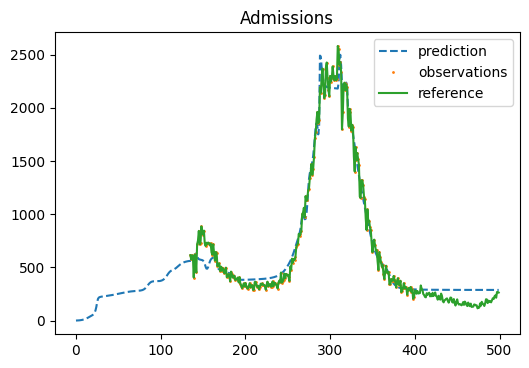

In [11]:
plt.figure(dpi=100)
plt.plot(t_ode.detach().cpu(), u_pred[:, 6:7], '--', label="prediction")
plt.plot(t_A, A_train, 'o', markersize=1, label="observations")
plt.plot(t_A_test, A_test, label="reference")
plt.title("Admissions")
plt.legend()
plt.show()

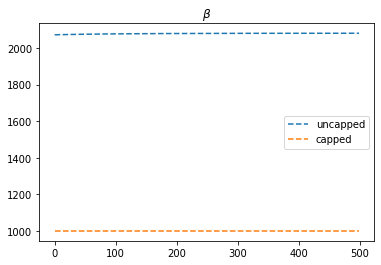

In [12]:
plt.plot(t_ode.detach().cpu(), beta_pred, '--', label="uncapped")
plt.plot(t_ode.detach().cpu(), torch.clip(beta_pred, max=1000), '--', label="capped")
# plt.plot(t_A, A_train, 'o', markersize=1, label="observations")
# plt.plot(t_A_test, A_test, label="reference")
plt.title("$\\beta$")
plt.legend()
plt.show()